In [180]:
%pip install gurobipy

In [181]:
import gurobipy as gp
from gurobipy import GRB

import numpy as np
import matplotlib.pyplot as plt

In [182]:
# The list companies contains the various companies that are trying to advertise
companies = ['GEICO', 'Delta', 'TMobile', 'CapitalOne']

# The list sections contains the two sections where the ads can be shown
sections = ['Sports','National'] #Adding a total section as there are constraints on the total as well


In [183]:
#Recreating the contracts and CTR table using Python multidict

combinations, views, ctr = gp.multidict({
            ('GEICO','Sports'):[2000000,0.025],
            ('GEICO','National'):[1000000,0.008],
            ('Delta','Sports'):[0,.02],
            ('Delta','National'):[1000000,0.01],
            ('TMobile','Sports'):[1000000,0.01],
            ('TMobile','National'):[1000000,0.03],
            ('CapitalOne','Sports'):[0,0.015],
            ('CapitalOne','National'):[0,0.02]
})

In [184]:
# Declare and initialize optimization model
m = gp.Model('RAP')

In [185]:
# Create decision variables for the RAP model
x = m.addVars(combinations, name="assign")

In [186]:
#Creating constraint for maximum possible views for Sports section
sports_max_constraint = m.addConstrs((x.sum('*',s) <= 6000000 for s in ['Sports']), name='sports_max')

#Creating constraint for maximum possible views for National section
national_max_constraint = m.addConstrs((x.sum('*',s) <= 5000000 for s in ['National']), name='national_max')

In [187]:
#Creating constraint on Views for GEICO in Sports section
geico_sports_constraint = m.addConstrs((x.sum(c,s) >= 2000000 for c in ['GEICO'] for s in ['Sports']), name='geico_sports_min')

#Creating constraint on Views for GEICO in National section
geico_national_constraint = m.addConstrs((x.sum(c,s) >= 1000000 for c in ['GEICO'] for s in ['National']), name='geico_national_min')

#Creating constraint on Views for Delta in National section
delta_national_constraint = m.addConstrs((x.sum(c,s) >= 1000000 for c in ['Delta'] for s in ['National']), name='delta_national_min')

#Creating constraint on Total Views for Delta across both sections
delta_total_constraint = m.addConstrs((x.sum(c,'*') >= 2000000 for c in ['Delta']), name='delta_total_min')

#Creating constraint on Views for T-Mobile in Sports section
tmobile_sports_constraint = m.addConstrs((x.sum(c,s) >= 1000000 for c in ['TMobile'] for s in ['Sports']), name='tmobile_sports_min')

#Creating constraint on Views for T-Mobile in National section
tmobile_national_constraint = m.addConstrs((x.sum(c,s) >= 1000000 for c in ['TMobile'] for s in ['National']), name='tmobile_national_min')

#Creating constraint on Total Views for T-Mobile across both sections
tmobile_total_constraint = m.addConstrs((x.sum(c,'*') >= 3000000 for c in ['TMobile']), name='tmobile_total_min')

#Creating constraint on Total Views for Capital One across both sections
capitalone_total_constraint = m.addConstrs((x.sum(c,'*') >= 2000000 for c in ['CapitalOne']), name='capitalone_total_min')

#Adding constraint that all the values should be >= 0
positive_constraint = m.addConstrs((x.sum(c,s) >= 0 for c in companies for s in sections), name='positive_constraint')

In [188]:
#Setting the objective function
m.setObjective(x.prod(ctr)*2.4, GRB.MAXIMIZE)

In [189]:
#Optimizing the model and obtaining the solution

m.write('RAP.lp')

m.optimize()

#print(m.display())

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 18 rows, 8 columns and 27 nonzeros
Model fingerprint: 0xa131361d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 7e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+06, 6e+06]
Presolve removed 13 rows and 1 columns
Presolve time: 0.01s
Presolved: 5 rows, 7 columns, 13 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.8320000e+05   3.750000e+05   0.000000e+00      0s
       3    5.2320000e+05   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.02 seconds (0.00 work units)
Optimal objective  5.232000000e+05


In [190]:
print(f'The maximum amount Washington Post can receive is ${m.getObjective().getValue()}\n') 

print('\nThe following are the views to be assigned to each combination: \n') 

for c, s in combinations:
    print(x[c, s].varName, x[c, s].x)

The maximum amount Washington Post can receive is $523200.0


The following are the views to be assigned to each combination: 

assign[GEICO,Sports] 3000000.0
assign[GEICO,National] 1000000.0
assign[Delta,Sports] 1000000.0
assign[Delta,National] 1000000.0
assign[TMobile,Sports] 1000000.0
assign[TMobile,National] 2000000.0
assign[CapitalOne,Sports] 1000000.0
assign[CapitalOne,National] 1000000.0


**Sensitivity Analysis**

In [191]:
x['GEICO','Sports']

<gurobi.Var assign[GEICO,Sports] (value 3000000.0)>

In [192]:
#Recreating the contracts and CTR table using Python multidict with multiple values of CTR
i = 0
views_optimal = [[],[],[],[],[],[],[]]
revenue = [0,0,0,0,0,0,0]
geico_ctr_list = np.linspace(0.005,0.035,7)

for i_ctr in geico_ctr_list:
  print(f'\n When CTRs for GEICO are {round(i_ctr*100,1)}%')

  combinations, views, ctr = gp.multidict({
            ('GEICO','Sports'):[2000000,i_ctr],
            ('GEICO','National'):[1000000,i_ctr],
            ('Delta','Sports'):[0,.02],
            ('Delta','National'):[1000000,0.01],
            ('TMobile','Sports'):[1000000,0.01],
            ('TMobile','National'):[1000000,0.03],
            ('CapitalOne','Sports'):[0,0.015],
            ('CapitalOne','National'):[0,0.02]
  })

  # Declare and initialize optimization model
  m = gp.Model('RAP')

  # Create decision variables for the RAP model
  x = m.addVars(combinations, name="assign") 

  #Creating constraint for maximum possible views for Sports section
  sports_max_constraint = m.addConstrs((x.sum('*',s) <= 6000000 for s in ['Sports']), name='sports_max')

  #Creating constraint for maximum possible views for National section
  national_max_constraint = m.addConstrs((x.sum('*',s) <= 5000000 for s in ['National']), name='national_max')

  #Creating constraint on Views for GEICO in Sports section
  geico_sports_constraint = m.addConstrs((x.sum(c,s) >= 2000000 for c in ['GEICO'] for s in ['Sports']), name='geico_sports_min')

  #Creating constraint on Views for GEICO in National section
  geico_national_constraint = m.addConstrs((x.sum(c,s) >= 1000000 for c in ['GEICO'] for s in ['National']), name='geico_national_min')

  #Creating constraint on Views for Delta in National section
  delta_national_constraint = m.addConstrs((x.sum(c,s) >= 1000000 for c in ['Delta'] for s in ['National']), name='delta_national_min')

  #Creating constraint on Total Views for Delta across both sections
  delta_total_constraint = m.addConstrs((x.sum(c,'*') >= 2000000 for c in ['Delta']), name='delta_total_min')

  #Creating constraint on Views for T-Mobile in Sports section
  tmobile_sports_constraint = m.addConstrs((x.sum(c,s) >= 1000000 for c in ['TMobile'] for s in ['Sports']), name='tmobile_sports_min')

  #Creating constraint on Views for T-Mobile in National section
  tmobile_national_constraint = m.addConstrs((x.sum(c,s) >= 1000000 for c in ['TMobile'] for s in ['National']), name='tmobile_national_min')

  #Creating constraint on Total Views for T-Mobile across both sections
  tmobile_total_constraint = m.addConstrs((x.sum(c,'*') >= 3000000 for c in ['TMobile']), name='tmobile_total_min')

  #Creating constraint on Total Views for Capital One across both sections
  capitalone_total_constraint = m.addConstrs((x.sum(c,'*') >= 2000000 for c in ['CapitalOne']), name='capitalone_total_min')

  #Adding constraint that all the values should be >= 0
  positive_constraint = m.addConstrs((x.sum(c,s) >= 0 for c in companies for s in sections), name='positive_constraint')

  #Setting the objective function
  m.setObjective(x.prod(ctr)*2.4, GRB.MAXIMIZE)

  #Optimizing the model and obtaining the solution
  m.write('RAP.lp')
  m.optimize()

  print(f'The maximum amount Washington Post can receive with GEICO CTR {round(i_ctr*100,1)}% is ${m.getObjective().getValue()}\n') 

  print(f'\nThe following are the views to be assigned to each combination with GEICO CTR {round(i_ctr*100,1)}% : \n') 

  for c, s in combinations:
      print(x[c, s].varName, x[c, s].x)
      views_optimal[i].append(x[c, s].x)
  revenue[i] = m.getObjective().getValue()
  i = i+1



 When CTRs for GEICO are 0.5%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 18 rows, 8 columns and 27 nonzeros
Model fingerprint: 0x740a8196
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 7e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+06, 6e+06]
Presolve removed 13 rows and 2 columns
Presolve time: 0.02s
Presolved: 5 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4400000e+05   2.500000e+05   0.000000e+00      0s
       1    4.2000000e+05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds (0.00 work units)
Optimal objective  4.200000000e+05
The maximum amount Washington Post can receive with GEICO CTR 0.5% is $420000.0


The following are the views to be assigned to each combination with GEICO CTR 0.5% : 

assign[GEICO,Sports] 2000000.0


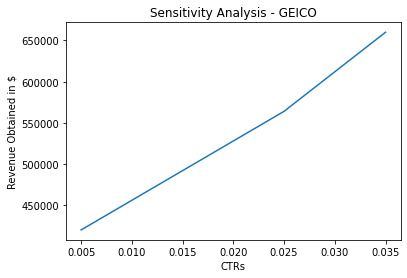

In [194]:

geico_ctr_list = list(geico_ctr_list)
# plotting the points
plt.plot(geico_ctr_list, revenue)
 
# naming the x axis
plt.xlabel('CTRs')
# naming the y axis
plt.ylabel('Revenue Obtained in $')
 
# giving a title to my graph
plt.title('Sensitivity Analysis - GEICO')
 
# function to show the plot
plt.show()

